In [1]:
import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

In [2]:
from pytorch_msssim import ms_ssim

In [3]:
from compressai.zoo import cheng2020_anchor

In [4]:
from ipywidgets import interact, widgets

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
metric = 'mse' 
quality = 1

cuda


In [6]:
model = cheng2020_anchor(quality=quality, pretrained=True).eval().to(device)

In [7]:
import cv2

tmp_img = cv2.imread('./assets/9.png') 
cv2.imwrite('./assets/9.jpg', tmp_img, [int(cv2.IMWRITE_JPEG_QUALITY), 7])

True

In [8]:
img = Image.oimg = Image.open('./assets/9.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

In [9]:
img_jpg = Image.oimg = Image.open('./assets/9.jpg').convert('RGB')
x_jpg = transforms.ToTensor()(img_jpg).unsqueeze(0).to(device)

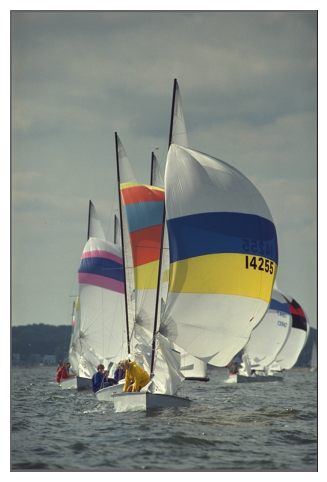

In [10]:
%matplotlib inline
plt.figure(figsize=(9, 6))
plt.axis('off')
plt.imshow(img)
plt.show()

In [11]:
with torch.no_grad():
    compressed = model(x)
    compressed['x_hat'].clamp_(0, 1)

In [12]:
reconstructed = transforms.ToPILImage()(compressed['x_hat'].squeeze())

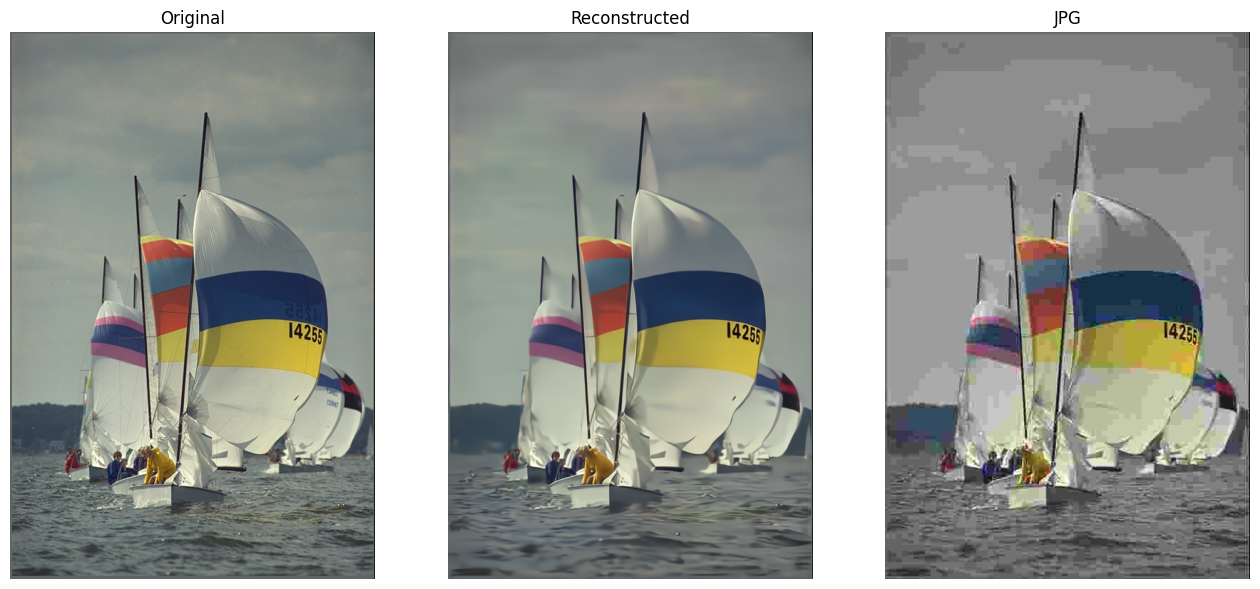

In [13]:
%matplotlib inline
fix, axes = plt.subplots(1, 3, figsize=(16, 12))
for ax in axes.ravel():
    ax.axis('off')
   
axes.ravel()[0].imshow(img)
axes.ravel()[0].title.set_text('Original')
    
axes.ravel()[1].imshow(reconstructed)
axes.ravel()[1].title.set_text('Reconstructed')

axes.ravel()[2].imshow(img_jpg)
axes.ravel()[2].title.set_text('JPG')

plt.show()

In [14]:
reconstructed.save("./assets/reconstructed.png")

In [15]:
ls -la assets

total 1668
drwxrwxr-x 3 shutkov shutkov   4096 мар  7 14:16 ./
drwxrwxr-x 4 shutkov shutkov   4096 мар  7 17:40 ../
-rw-rw-r-- 1 shutkov shutkov  11113 мар  7 17:42 9.jpg
-rw-rw-r-- 1 shutkov shutkov 582899 мар  7 14:04 9.png
drwxrwxr-x 2 shutkov shutkov   4096 мар  7 13:50 .ipynb_checkpoints/
-rw-rw-r-- 1 shutkov shutkov 302373 мар  7 17:42 reconstructed.png
-rw-rw-r-- 1 shutkov shutkov 794058 мар  7 13:10 stmalo_fracape.png


In [16]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [17]:
metrics = {}
metrics["cheng2020_anchor"] = {
    'psnr': compute_psnr(x, compressed["x_hat"]),
    'ms-ssim': compute_msssim(x, compressed["x_hat"]),
    'bit-rate': compute_bpp(compressed),
}
metrics

{'cheng2020_anchor': {'psnr': 30.86451313434267,
  'ms-ssim': 0.9578922986984253,
  'bit-rate': 0.07136543095111847}}

In [18]:
import os

metrics["jpg"] = {
    'psnr': compute_psnr(x, x_jpg),
    'ms-ssim': compute_msssim(x, x_jpg),
    'bit-rate': os.path.getsize("./assets/9.jpg") * 8 / (x_jpg.shape[-1] * x_jpg.shape[-2] * x_jpg.shape[-3]),
}

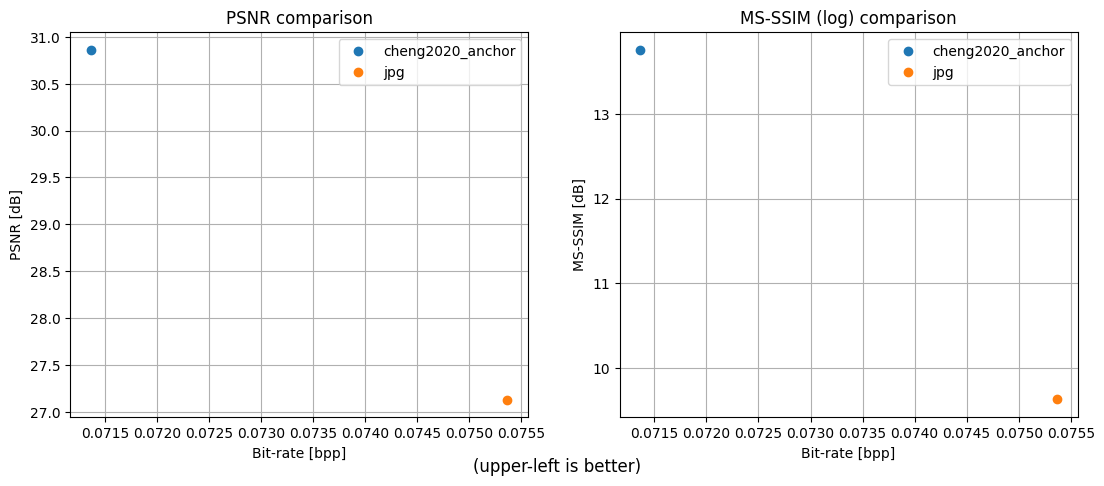

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')
for name, m in metrics.items():
    axes[0].plot(m['bit-rate'], m['psnr'], 'o', label=name)
    axes[0].legend(loc='best')
    axes[0].grid(True)
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    axes[1].plot(m['bit-rate'], -10*np.log10(1-m['ms-ssim']), 'o', label=name)
    axes[1].legend(loc='best')
    axes[1].grid(True)
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

plt.show()

In [20]:
import os 
images = []
path = '/home/shutkov/Kodak-Lossless-True-Color-Image-Suite/PhotoCD_PCD0992'

for f in os.listdir(path):
    images.append(Image.open(os.path.join(path, f)).convert('RGB'))

In [21]:
psnr = torch.zeros((2, len(images), 6))
ssim = torch.zeros((2, len(images), 6))
bpp = torch.zeros((2, len(images), 6))

for n2, model_quality in enumerate(range(1, 7)):
    model = cheng2020_anchor(quality=model_quality, pretrained=True).eval().to(device)
    for n1, img in enumerate(images):
        x = transforms.ToTensor()(img).unsqueeze(0).to(device)
        
        compressed = model(x)
        compressed['x_hat'].clamp_(0, 1)

        psnr[0, n1, n2] = compute_psnr(x, compressed["x_hat"])
        ssim[0, n1, n2] = compute_msssim(x, compressed["x_hat"])
        bpp[0, n1, n2] = compute_bpp(compressed)

In [49]:
for n2, jpg_quality in enumerate(range(10, 100, 15)):
    for n1, img in enumerate(images):
        x = transforms.ToTensor()(img).unsqueeze(0).to(device)

        cv2.imwrite('./assets/tmp.jpg', np.array(img), [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])
        img_jpg = Image.oimg = Image.open('./assets/tmp.jpg').convert('RGB')
        x_jpg = transforms.ToTensor()(img_jpg).unsqueeze(0).to(device)
        
        psnr[1, n1, n2] = compute_psnr(x, x_jpg)
        ssim[1, n1, n2] = compute_msssim(x, x_jpg)
        bpp[1, n1, n2] = os.path.getsize("./assets/tmp.jpg") * 8 / (x_jpg.shape[-1] * x_jpg.shape[-2] * x_jpg.shape[-3])

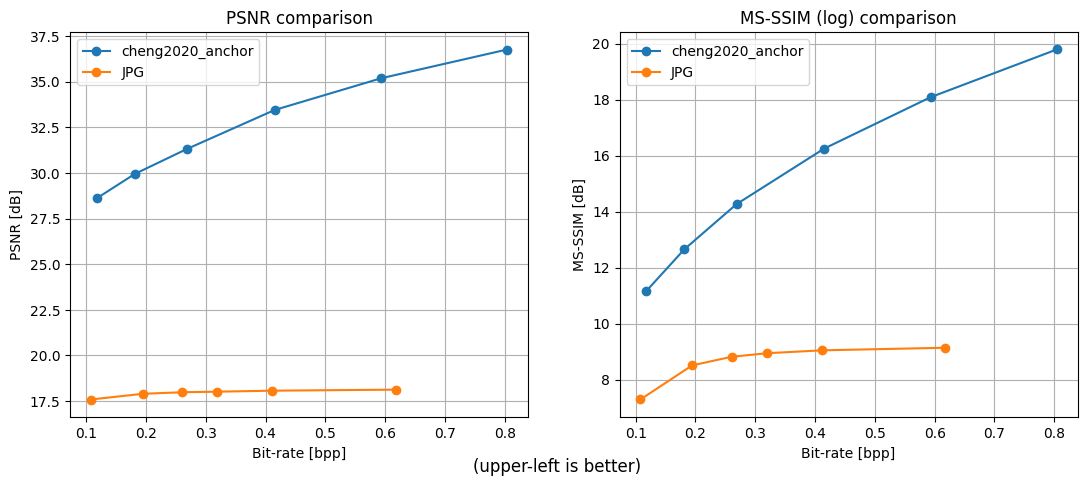

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
plt.figtext(.5, 0., '(upper-left is better)', fontsize=12, ha='center')
labels = ["cheng2020_anchor", "JPG"]

for i in range(2):
    axes[0].plot(torch.mean(bpp[i], axis=0), torch.mean(psnr[i], axis=0), label=labels[i], marker='o')
    axes[0].legend(loc='best')
    axes[0].grid(True)
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')
    
    axes[1].plot(torch.mean(bpp[i], axis=0), -10*np.log10(1-torch.mean(ssim[i], axis=0)), label=labels[i], marker='o')
    axes[1].legend(loc='best')
    axes[1].grid(True)
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM (log) comparison')

In [ ]:
import tensorflow as tf

def create_adversarial_pattern(original, model):
  with tf.GradientTape() as tape:
    tape.watch(original)
    compressed = model(original)
    loss = mse_loss_fn(original, compressed)

  gradient = tape.gradient(loss, original)
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
perturbations = create_adversarial_pattern(x, model)
plt.imshow(perturbations[0] * 0.5 + 0.5)

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [ ]:
def mse_loss_fn(original, compressed):
    lambdas = [0.0018, 0.0035, 0.0067, 0.0130, 0.0250, 0.0483]
    D = compute_psnr(original, compressed["x_hat"])
    R = compute_bpp(compressed)
    return lambdas[quality-1] * 255**2 * D + R

def test( model, image, epsilon):
    correct = 0
    adv_examples = []

    image.requires_grad = True
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1]

    loss = mse_loss_fn(image, output)
    
    model.zero_grad()
    loss.backward()
    image_grad = image.grad.data
    image_denorm = denorm(image)
    
    perturbed_image = fgsm_attack(image_denorm, epsilon, image_grad)
    perturbed_image_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_image)

    return perturbed_image_normalized

In [ ]:
atacked_image = test(model, x, 0.007)